In [1]:
# Load drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import os
os.listdir()

['.config', 'gdrive', 'sample_data']

In [3]:
import matplotlib.pyplot as plt

In [4]:
import json
key_file = open('/content/gdrive/MyDrive/MUStARD-master/data/sarcasm_data.json')
data = json.load(key_file)

key_order = list(data.keys())

In [5]:
# Load Individual Data

import pickle
import numpy as np

text_loc = "/content/gdrive/MyDrive/Pickle_Data/text_bert_embeddings.pkl"
audio_loc = "/content/gdrive/MyDrive/Pickle_Data/audio_features.pkl"
video_loc = "/content/gdrive/MyDrive/Pickle_Data/video_features.pkl"
label_map_loc = "/content/gdrive/MyDrive/Pickle_Data/label_map.pkl"

# Text features are available as numpy array in the key_order order
text_feats = pickle.load(open(text_loc, "rb"))

# Audio and Video Features are available as dict in random order - We pre-process them
audio_dict = pickle.load(open(audio_loc, "rb"))
video_dict = pickle.load(open(video_loc, "rb"))

# Label map: Key ---> Ground Truth Label
label_map = pickle.load(open(label_map_loc, "rb"))

# Final Extracted Features
audio_feats = []
video_feats = []

# Ground Truth Labels
y = []

for key in key_order:
  audio_feats.append(audio_dict[key])
  video_feats.append(video_dict[key])
  y.append(label_map[key])

text_feats = np.array(text_feats).astype('float32')
audio_feats = np.array(audio_feats).astype('float32')
video_feats = np.array(video_feats).astype('float32')
y = np.array(y).astype('float32')

In [6]:
np.shape(text_feats), np.shape(audio_feats), np.shape(video_feats)

((690, 768), (690, 283), (690, 2048))

# Mean Difference Calculation

5% = 47  10% = 3


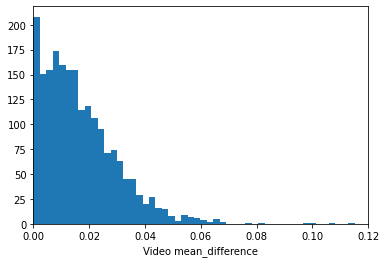

In [7]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()

def find_changes(x, y_sarcasm, y_not_sarcasm):
  top_difference = []
  x = sc.fit_transform(x)
  for i in range(np.shape(x)[1]):
    f1_sarcasm = x[y_sarcasm, i]
    f1_not_sarcasm = x[y_not_sarcasm, i]
    top_difference.append((abs(np.mean(f1_sarcasm) - np.mean(f1_not_sarcasm))))
  
  print(f"5% = {np.sum(np.array(top_difference) > 0.05)}  10% = {np.sum(np.array(top_difference) > 0.1)}")
  plt.hist(top_difference, bins=50)
  plt.xlim(0,0.12)
  plt.xlabel('Video mean_difference')
  plt.show()

y_sarcasm = [i for i in range(len(y)) if y[i]==1]
y_not_sarcasm = [i for i in range(len(y)) if y[i]==0]

# find_changes(text_feats, y_sarcasm, y_not_sarcasm)
# find_changes(audio_feats, y_sarcasm, y_not_sarcasm)
find_changes(video_feats, y_sarcasm, y_not_sarcasm)

#EDA

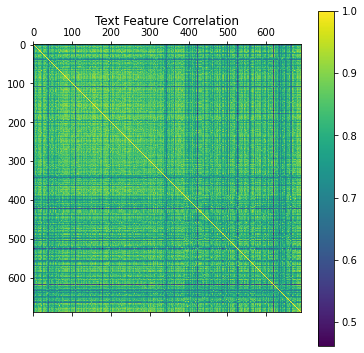

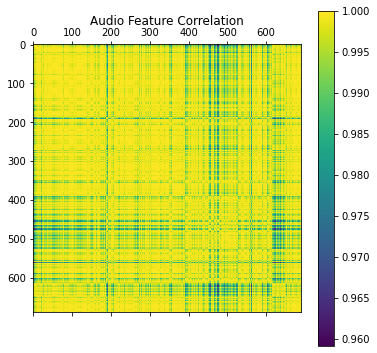

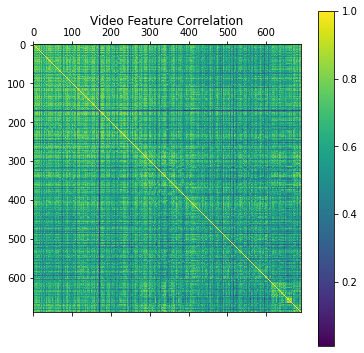

In [8]:
text_corr = np.corrcoef(text_feats)

plt.figure(figsize=(6,6))
plt.matshow(text_corr, fignum=1)
plt.title('Text Feature Correlation')
plt.colorbar()
plt.show()

audio_corr = np.corrcoef(audio_feats)

plt.figure(figsize=(6,6))
plt.matshow(audio_corr, fignum=1)
plt.title('Audio Feature Correlation')
plt.colorbar()
plt.show()

video_corr = np.corrcoef(video_feats)

plt.figure(figsize=(6,6))
plt.matshow(video_corr, fignum=1)
plt.title('Video Feature Correlation')
plt.colorbar()
plt.show()

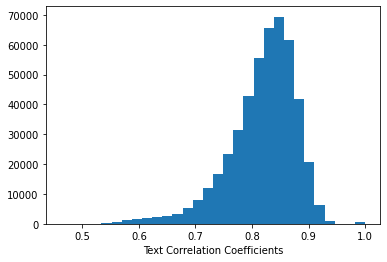

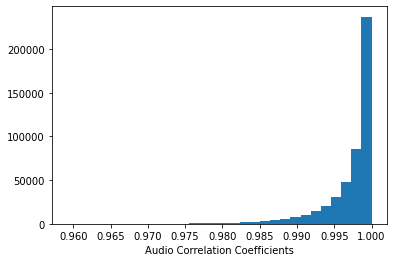

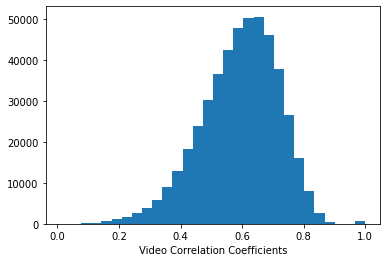

In [9]:
plt.hist(np.reshape(text_corr, -1), bins=30)
plt.xlabel('Text Correlation Coefficients')
plt.show()

plt.hist(np.reshape(audio_corr, -1), bins=30)
plt.xlabel('Audio Correlation Coefficients')
plt.show()

plt.hist(np.reshape(video_corr, -1), bins=30)
plt.xlabel('Video Correlation Coefficients')
plt.show()


#Combined Analysis

In [32]:
# Concatenate all the modalities: Text - Audio - Video
X = np.concatenate([text_feats, audio_feats, video_feats], axis=1)
#X = np.concatenate([audio_feats], axis=1)

# Scale all the data values to 0-1 using min-max scalar
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

# Find sarcasm and not-sarcasm data indices (rows)
y_sarcasm = [i for i in range(len(y)) if y[i]==True]
y_not_sarcasm = [i for i in range(len(y)) if y[i]==False]

# Definition for computing histogram Overlap

def find_overlap(d1, d2):
  h1 = plt.hist(d1, bins=100)
  h2 = plt.hist(d2, bins=100)
  return np.sum(np.minimum(h1[0], h2[0]))

# Find the most important features: Using Max Drift
top_difference = []
for i in range(np.shape(X)[1]):
  f1_sarcasm = X[y_sarcasm, i]
  f1_not_sarcasm = X[y_not_sarcasm, i]
  top_difference.append((abs(np.mean(f1_sarcasm) - np.mean(f1_not_sarcasm))))
  # top_difference.append(find_overlap(f1_sarcasm, f1_not_sarcasm))

# Get the top 200 drifted features
max_drifted_features = np.argsort(top_difference)[::-1]
# max_drifted_features = np.argsort(top_difference)

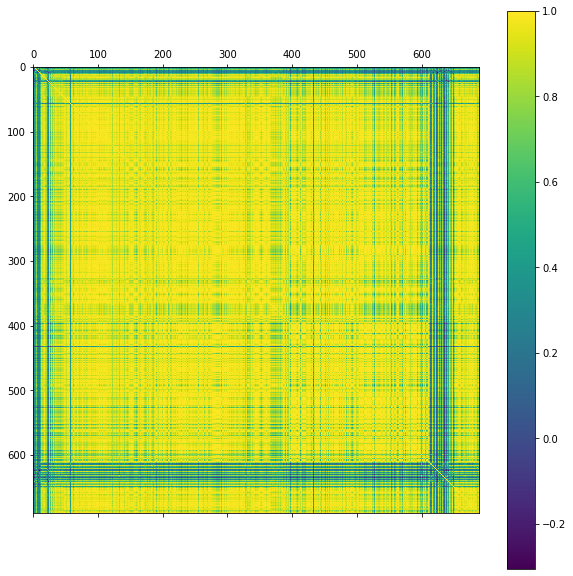

In [11]:
# Correlation matrix for the top-k most drifted features
k = 25
top_k = X[:, max_drifted_features[0:k]]
top_k_cor = np.corrcoef(top_k)
plt.figure(figsize=(10,10))
plt.matshow(top_k_cor, fignum=1)
plt.colorbar()
plt.show()

In [12]:
n_text = np.shape(text_feats)[1]
n_audio = np.shape(audio_feats)[1]
n_video = np.shape(video_feats)[1]

for i in range(20):
  cur_feat = max_drifted_features[i]
  if cur_feat < n_text:
    print(f"{i+1} Text_{cur_feat} {top_difference[cur_feat]}")
  elif cur_feat < n_text + n_audio:
    print(f"{i+1} Audio_{cur_feat - n_text} {top_difference[cur_feat]}")
  else:
    print(f"{i+1} Video_{cur_feat - n_text - n_audio} {top_difference[cur_feat]}")

1 Text_0 0.12447512149810791
2 Text_123 0.04562550038099289
3 Text_127 0.045456551015377045
4 Text_36 0.04131180793046951
5 Text_282 0.04033845663070679
6 Text_102 0.035944949835538864
7 Text_105 0.035846445709466934
8 Text_43 0.03466298058629036
9 Text_48 0.034301646053791046
10 Text_104 0.03374502807855606
11 Text_44 0.03304567188024521
12 Text_143 0.03260701149702072
13 Text_56 0.03225521743297577
14 Text_111 0.03171975538134575
15 Text_91 0.03129062056541443
16 Text_120 0.030914202332496643
17 Text_121 0.03057916648685932
18 Text_88 0.030213139951229095
19 Text_47 0.029832907021045685
20 Text_66 0.029604945331811905


# Feature Selection - Top Drifted

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
import xgboost as xgb

In [44]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
import xgboost as xgb

clf = xgb.XGBClassifier(objective="binary:logistic", random_state=42,max_depth=2,n_estimators=135)
# clf = GaussianNB()
#clf = RandomForestClassifier(max_depth=2, n_estimators = 100, random_state=0)

test_score = []
select_num_feats = []
store_all = []

for r in range(0,10):
  
  X_tv, X_test, y_tv, y_test = train_test_split(X, y, test_size=0.10, random_state=r)
  kf = KFold(n_splits = 5, shuffle = True, random_state = r)
  
  mean_score = []
  score = []

  for k in range(1,y.shape[0],20):
  
    temp_score = []
  
    for train_index, test_index in kf.split(X_tv):
  
      X_train, y_train = X_tv[train_index], y_tv[train_index]
      X_val, y_val = X_tv[test_index], y_tv[test_index]
      y_pred = clf.fit(X_train[:,max_drifted_features[0:k]], y_train).predict(X_val[:,max_drifted_features[0:k]])
      temp_score.append(f1_score(y_val, y_pred))
  
    score.append(temp_score)
    mean_score.append(np.mean(temp_score))
  
  store_all.append(mean_score)
  num_features = np.argsort(mean_score)[-1] + 1
  select_num_feats.append(num_features)
  y_pred = clf.fit(X_tv[:, max_drifted_features[0:num_features]], y_tv).predict(X_test[:, max_drifted_features[0:num_features]])
  test_score.append(f1_score(y_test, y_pred))

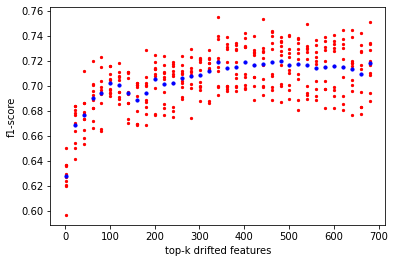

In [46]:
for r in store_all:
  plt.scatter(np.arange(1,y.shape[0],20), r, s=5, c='r', label='actual values')
plt.scatter(np.arange(1,y.shape[0],20), np.mean(store_all, axis=0), s=10, c='b', label='mean values')
plt.xlabel('top-k drifted features')
plt.ylabel('f1-score')
plt.show()

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score

kf = KFold(n_splits = 10, shuffle = True, random_state = 0)
X = np.array(X)
k = 40
clf = SVC(probability=True)
# clf = GaussianNB()

temp_score_f1 = []
temp_score_acc = []
temp_score_pre = []
temp_score_rec = []
temp_score_auc = []


for train_index, test_index in kf.split(X):
  X_train, y_train = X[train_index], y[train_index]
  X_val, y_val = X[test_index], y[test_index]
  y_pred = clf.fit(X_train[:,max_drifted_features[0:k]], y_train).predict(X_val[:,max_drifted_features[0:k]])
  temp_score_f1.append(f1_score(y_val, y_pred))
  temp_score_acc.append(accuracy_score(y_val, y_pred))
  temp_score_pre.append(precision_score(y_val, y_pred))
  temp_score_rec.append(recall_score(y_val, y_pred))
  temp_score_auc.append(roc_auc_score(y_val, 1 - clf.fit(X_train[:,max_drifted_features[0:k]], y_train).predict_proba(X_val[:,max_drifted_features[0:k]])[:,0:1]))

print(f"F1 Score = {np.mean(temp_score_f1)} +- {np.std(temp_score_f1)}")
print(f"Accuracy Score = {np.mean(temp_score_acc)} +- {np.std(temp_score_acc)}")
print(f"Precision Score = {np.mean(temp_score_pre)} +- {np.std(temp_score_pre)}")
print(f"Recall Score = {np.mean(temp_score_rec)} +- {np.std(temp_score_rec)}")
print(f"ROC AUC Score = {np.mean(temp_score_auc)} +- {np.std(temp_score_auc)}")

F1 Score = 0.647233934073826 +- 0.04405140943429826
Accuracy Score = 0.644927536231884 +- 0.04455195985199825
Precision Score = 0.6477112696662284 +- 0.08592317439217415
Recall Score = 0.655040569734345 +- 0.03821545001544216
ROC AUC Score = 0.7092947045538802 +- 0.05162827946615035


In [18]:
temp_score

[0.7651006711409396,
 0.6875000000000001,
 0.5873015873015874,
 0.7083333333333334,
 0.6715328467153285]

In [ ]:
kf = KFold(n_splits = 10, shuffle = True, random_state = 0)
X = np.array(X)
k = 107

from sklearn.mixture import GaussianMixture
# clf = GaussianMixture(n_components=2)
clf = SVC()
# clf = GaussianNB()
temp_score = []

for train_index, test_index in kf.split(X):
  X_train, y_train = X[train_index], y[train_index]
  X_val, y_val = X[test_index], y[test_index]
  y_pred = clf.fit(X_train[:,max_drifted_features[0:k]], y_train).predict(X_val[:,max_drifted_features[0:k]])
  temp_score.append(f1_score(y_val, y_pred))
print(temp_score)
print(f"F1 Score = {np.mean(temp_score)} +- {np.std(temp_score)}")

[0.6857142857142857, 0.6666666666666666, 0.6944444444444444, 0.7058823529411765, 0.7246376811594202, 0.6923076923076924, 0.6567164179104478, 0.5882352941176471, 0.6578947368421053, 0.6756756756756757]
F1 Score = 0.6748175247779561 +- 0.03526275551311867


In [31]:
X.shape

(690, 283)

# PCA Analysis

Total Accounted Variance = 77.12032794952393


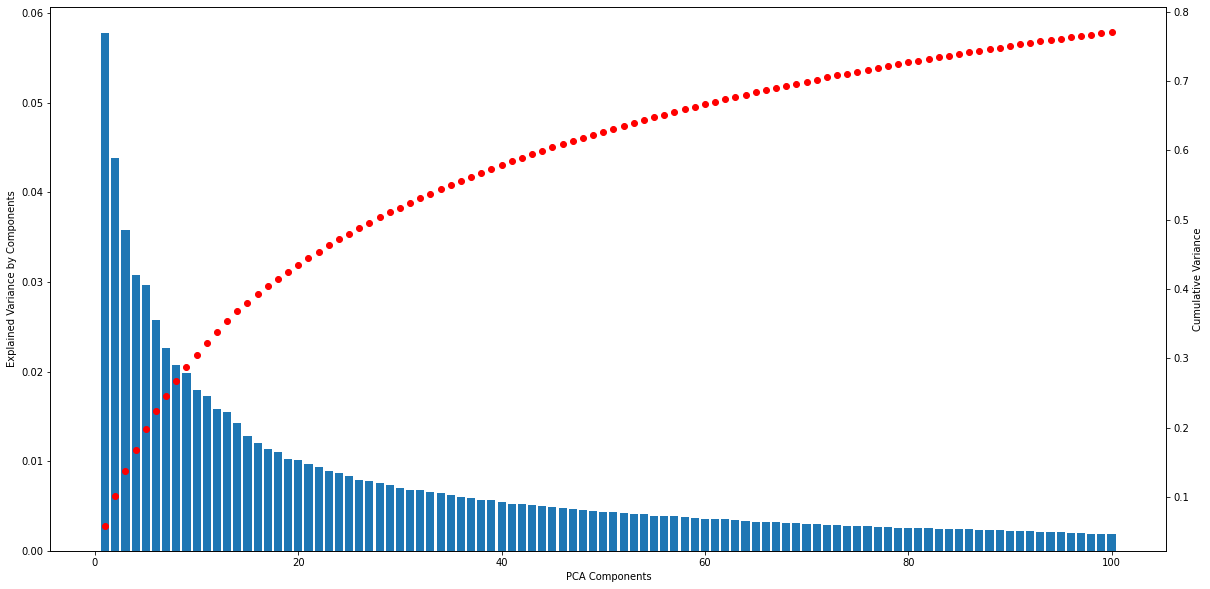

In [35]:
from sklearn.decomposition import PCA
pca_components = 100
pca = PCA(n_components=pca_components)
X_d = pca.fit_transform(X)

pca_variance = pca.explained_variance_ratio_
cum_variance = []
sum = 0
for v in pca_variance:
  sum += v
  cum_variance.append(sum)

print(f"Total Accounted Variance = {np.sum(pca_variance)*100}")

fig,ax1 = plt.subplots()
fig.set_size_inches(20,10)
ax2 = ax1.twinx()
ax2.scatter(np.arange(1, pca_components+1), cum_variance, c='r')
ax2.set_ylabel('Cumulative Variance')
ax1.set_ylabel('Explained Variance by Components')
ax1.set_xlabel('PCA Components')
ax1.bar(np.arange(1,pca_components+1), pca_variance)
plt.show()

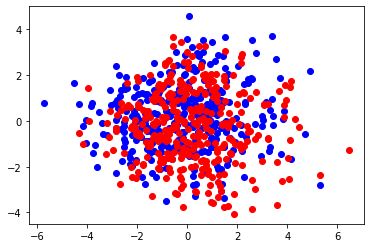

In [36]:
plt.scatter(X_d[y_sarcasm, 0], X_d[y_sarcasm, 1], c='b')
plt.scatter(X_d[y_not_sarcasm, 0], X_d[y_not_sarcasm, 1], c='r')
plt.show()

In [37]:
pca.components_[0,:]

array([-0.00250809,  0.00744458,  0.00124759, ...,  0.02846232,
        0.01054948,  0.01996212], dtype=float32)

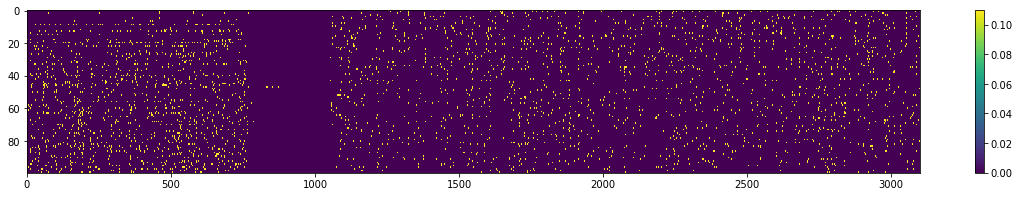

In [38]:
f_contribution = abs(pca.components_) > 0.04
plt.figure(figsize=(20,3))
plt.imshow(f_contribution, interpolation='nearest', aspect='auto', vmax=0.11, vmin=0)
plt.colorbar()
plt.show()

In [23]:
pc1 = [1, 2, 3, 0.1, 9, 99, 100, 0.4]
[100, 99, 9, 3, 2, 1, 0.4, 0.1]
100 - text_feat1
99 - text_feat2

NameError: ignored

In [24]:
np.sum(f_contribution[:,0:n_text])/(pca_components * n_text), np.sum(f_contribution[:,n_text+1:n_text+n_audio])/(pca_components * n_audio), np.sum(f_contribution[:,n_text+n_audio+1:])/(pca_components * n_video) 

(0.14036458333333332, 0.0, 0.0)

In [ ]:
# Is there a relation between PCA and top_drifted features?

top_contributions = np.argsort(f_contribution, axis=1)
for r in top_contributions:
  print(list(set(r[0:100]) & (set(max_drifted_features[0:200]))))

In [ ]:
# Text - Audio - Video Contribution to the PCA components

mod_contributions = []
n_com = 50
top_contributions = np.argsort(f_contribution, axis=1)[:,0:n_com]

n_text = np.shape(text_feats)[1]
n_audio = np.shape(audio_feats)[1]
n_video = np.shape(video_feats)[1]

for r in top_contributions:
  temp = []
  temp.append(np.sum(r < n_text))
  # print(temp[-1], np.sum(r < n_text + n_audio))
  temp.append(np.sum(r < n_text + n_audio) - temp[-1])
  temp.append(n_com - temp[-1] - temp[-2])
  mod_contributions.append(temp)

mod_contributions = np.array(mod_contributions)/n_com
# print(mod_contributions)
plt.figure(figsize=(2,20))
plt.imshow(mod_contributions, interpolation='nearest', aspect='auto')
plt.colorbar()
plt.show()

np.sum(mod_contributions, axis=0), np.sum(mod_contributions)

In [ ]:
# Text - Audio - Video Contribution to the PCA components

mod_contributions = []
n_com = 1
top_contributions = np.argsort(f_contribution, axis=1)

n_text = np.shape(text_feats)[1]
n_audio = np.shape(audio_feats)[1]
n_video = np.shape(video_feats)[1]

ind_cont = []
for i in range(0,100):
  r = top_contributions[i,0:200]
  temp = []
  temp.append(np.sum(r < n_text))
  temp.append(np.sum(r < n_text + n_audio) - temp[-1])
  temp.append(200 - temp[-1] - temp[-2])
  ind_cont.append(temp)

ind_cont

# Feature Reduction - PCA

In [30]:
X.shape

(690, 283)

Total Accounted Variance = 98.73674511909485


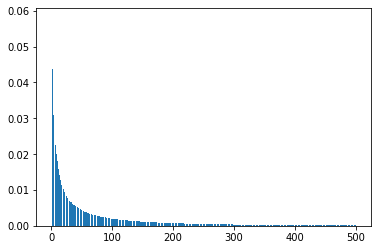

In [41]:
# PCA Application on the most drifted features

# X_d = X[:, max_drifted_features]
X_d = X

from sklearn.decomposition import PCA
pca_components = 500
pca = PCA(n_components=pca_components)
X_d = pca.fit_transform(X_d)

pca_variance = pca.explained_variance_ratio_
print(f"Total Accounted Variance = {np.sum(pca_variance)*100}")
plt.bar(np.arange(1,pca_components+1), pca_variance)
plt.show()


# Analysing the performance of PCA feature reduction

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn.svm import SVC
from sklearn.model_selection import KFold

#clf = SVC()
# clf = GaussianNB()
#clf = xgb.XGBClassifier(objective="binary:logistic", random_state=42,max_depth=2,n_estimators=135)
clf = RandomForestClassifier(max_depth=2, n_estimators = 100, random_state=0)

test_score = []
store_all = []

for r in range(0,10):
  
  X_tv, X_test, y_tv, y_test = train_test_split(X_d, y, test_size=0.10, random_state=r)
  kf = KFold(n_splits = 5, shuffle = True, random_state = r)
  
  mean_score = []
  score = []

  for k in range(1,pca_components,10):
  
    temp_score = []
  
    for train_index, test_index in kf.split(X_tv):
  
      X_train, y_train = X_tv[train_index], y_tv[train_index]
      X_val, y_val = X_tv[test_index], y_tv[test_index]
      y_pred = clf.fit(X_train[:,0:k], y_train).predict(X_val[:,0:k])
      temp_score.append(f1_score(y_val, y_pred))
  
    score.append(temp_score)
    mean_score.append(np.mean(temp_score))
  store_all.append(mean_score)
  num_features = np.argsort(mean_score)[-1] + 1
  y_pred = clf.fit(X_tv[:, 0:k], y_tv).predict(X_test[:, 0:k])
  test_score.append(f1_score(y_test, y_pred))

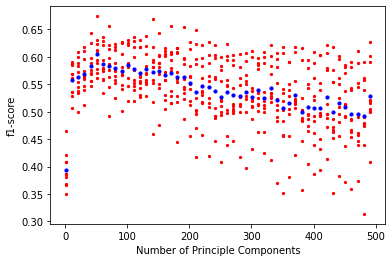

In [43]:
plt.rcParams['axes.facecolor'] = 'white'
for r in store_all:
  plt.scatter(np.arange(1,500,10), r, s=5, c='r', label='actual values')
plt.scatter(np.arange(1,500,10), np.mean(store_all, axis=0), s=10, c='b', label='mean values')
plt.xlabel('Number of Principle Components')
plt.ylabel('f1-score')
plt.show()

In [ ]:
kf = KFold(n_splits = 10, shuffle = True, random_state = 0)

from sklearn.decomposition import PCA
pca_components = 100
pca = PCA(n_components=pca_components)
X_d = pca.fit_transform(X)

X = np.array(X_d)
k = 100
clf = SVC(probability=True)
# clf = GaussianNB()
temp_score_f1 = []
temp_score_acc = []
temp_score_pre = []
temp_score_rec = []
temp_score_auc = []


for train_index, test_index in kf.split(X):
  X_train, y_train = X[train_index], y[train_index]
  X_val, y_val = X[test_index], y[test_index]
  y_pred = clf.fit(X_train[:,0:k], y_train).predict(X_val[:,0:k])

  temp_score_f1.append(f1_score(y_val, y_pred))
  temp_score_acc.append(accuracy_score(y_val, y_pred))
  temp_score_pre.append(precision_score(y_val, y_pred))
  temp_score_rec.append(recall_score(y_val, y_pred))
  temp_score_auc.append(roc_auc_score(y_val, 1 - clf.fit(X_train[:,0:k], y_train).predict_proba(X_val[:,0:k])[:,0:1]))

print(f"F1 Score = {np.mean(temp_score_f1)} +- {np.std(temp_score_f1)}")
print(f"Accuracy Score = {np.mean(temp_score_acc)} +- {np.std(temp_score_acc)}")
print(f"Precision Score = {np.mean(temp_score_pre)} +- {np.std(temp_score_pre)}")
print(f"Recall Score = {np.mean(temp_score_rec)} +- {np.std(temp_score_rec)}")
print(f"ROC AUC Score = {np.mean(temp_score_auc)} +- {np.std(temp_score_auc)}")

F1 Score = 0.6852032952641276 +- 0.03441039336410481
Accuracy Score = 0.673913043478261 +- 0.03383367399979351
Precision Score = 0.6634315471911859 +- 0.06599297544161183
Recall Score = 0.7148451982073037 +- 0.037603125760643695
ROC AUC Score = 0.7392456943623444 +- 0.03455157010012493


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score

kf = KFold(n_splits = 10, shuffle = True, random_state = 0)
X = np.array(X)
k = 107
clf = SVC()
# clf = GaussianNB()

temp_score_f1 = []
temp_score_acc = []
temp_score_pre = []
temp_score_rec = []


for train_index, test_index in kf.split(X):
  X_train, y_train = X[train_index], y[train_index]
  X_val, y_val = X[test_index], y[test_index]
  y_pred = clf.fit(X_train[:,max_drifted_features[0:k]], y_train).predict(X_val[:,max_drifted_features[0:k]])
  
  temp_score_f1.append(f1_score(y_val, y_pred))
  temp_score_acc.append(accuracy_score(y_val, y_pred))
  temp_score_pre.append(precision_score(y_val, y_pred))
  temp_score_rec.append(recall_score(y_val, y_pred))

print(f"F1 Score = {np.mean(temp_score_f1)} +- {np.std(temp_score_f1)}")
print(f"Accuracy Score = {np.mean(temp_score_acc)} +- {np.std(temp_score_acc)}")
print(f"Precision Score = {np.mean(temp_score_pre)} +- {np.std(temp_score_pre)}")
print(f"Recall Score = {np.mean(temp_score_rec)} +- {np.std(temp_score_rec)}")

IndexError: ignored